# Speech Emotion Recognition with CNNs and Transformer: A Parallel Model

**In this notebook, I'm going to build upon my [Intro to Speech Audio Classification repo](https://github.com/IliaZenkov/sklearn-audio-classification) and build a convolutional neural network (CNN) stacked in parallel with a Transformer encoder-decoder network to classify audio data. We're working on the [RAVDESS dataset](https://smartlaboratory.org/ravdess/) to classify emotions from one of 8 classes.** 

From my previous notebook: "Long-Short-Term-Memory Recurrent Neural Networks (LSTM RNNs) and Convolutional Neural Networks (CNNs) are excellent DNN candidates for audio data classification: LSTM RNNs because of their excellent ability to interpret sequential data such as the audio waveform represented as a time series; CNNs because features engineered on audio data such as spectrograms have marked resemblance to images, in which CNNs excel at recognizing and discriminating between distinct patterns." - Me 

I'm going to build on that - CNNs are still the hallmark of image classification today, although even in this domain Transformers are beginning to take the main stage: A [2021 ICLR submission: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://openreview.net/forum?id=YicbFdNTTy) claims they've implemented a Transformer for image classification that outperforms a state of the art CNN, and at a much lower computational complexity.

In addition to taking inspiration from the above, it's also no longer 2015 - so **as the successor of the LSTM-RNN I'm going to implemenet a Transformer model in parallel with a CNN to try and get sorta-state-of-the-art performance on the RAVDESS dataset.** Let's get to it.

#### Get imports out of the way

In [167]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import warnings; warnings.filterwarnings('ignore') #matplot lib complains about librosa

## Define features:

Define features as in the previous notebook on this task from my ['sklearn-audio-classification' repo](https://github.com/IliaZenkov/sklearn-audio-classification). That notebook explains the motivation behind the Mel Spectrogram - in short, we're looking for transitions in audible pitch frequencies. 

**We're doing away with the chromagram and MFCCs - with this model Mel Spectrograms to provide as good an accuracy as using all three, and we don't want extra complexity in a highly parameterized deep neural net such as this one** where we don't absolutely need it.



In [168]:
# RAVDESS native sample rate is 48k
sample_rate = 48000

def feature_melspectrogram(
    waveform, 
    sample_rate,
    fft = 1024,
    winlen = 512,
    window='hamming',
    hop=256,
    mels=128,
    ):
    
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram = librosa.feature.melspectrogram(
        y=waveform, 
        sr=sample_rate, 
        n_fft=fft, 
        win_length=winlen, 
        window=window, 
        hop_length=hop, 
        n_mels=mels, 
        fmax=sample_rate/2)
    
    # convert from power (amplitude**2) to decibels
    melspectrogram = librosa.power_to_db(melspectrogram, ref=np.max)
    
    return melspectrogram

def get_features(file):
    
    # load an individual sample audio file
    # read the full 3 seconds of the file, cut off the first 0.5s of silence; native sample rate = 48k
    # don't need to store the sample rate that librosa.load returns
    waveform, _ = librosa.load(file, duration=3, offset=0.5, sr=sample_rate)
    
    # make sure waveform vectors are homogenous by defining explicitly
    waveform_homo = np.zeros((int(sample_rate*3,)))
    waveform_homo[:len(waveform)] = waveform
    
    # compute spectrogram features from audio waveform                                      
    melspectrogram = feature_melspectrogram(waveform_homo, sample_rate)

    return melspectrogram, waveform_homo
    
# RAVDESS dataset emotions
emotions_dict ={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

# Additional attributes from RAVDESS to play with
emotion_attributes = {
    '01': 'normal',
    '02': 'strong'
}

## Load the data:

We process each file in the dataset and extract its features.

We return the features and the labels (from the file names of the RAVDESS audio samples). We also return the raw waveforms because we're going to do some extra processing.

In [169]:
import os, glob

data_path = ".\\RAVDESS dataset\\actor_*\\*.wav"

def load_data():
    # features and labels
    X,y=[],[]
    # raw waveforms to augment later
    waveforms = []
    # extra labels
    y_intensity, y_gender = [],[]
    # progress counter
    file_count = 0
    
    for file in glob.glob(data_path):
        file_name = os.path.basename(file)
        
        # get labels of the sample
        emotion = emotions_dict[file_name.split("-")[2]]
        intensity = emotion_attributes[file_name.split("-")[3]]
        if (int((file_name.split("-")[6]).split(".")[0]))%2==0: 
            gender = 'female' 
        else: 
            gender = 'male'
            
        # extract features form the sample
        features, waveform = get_features(file)
        
        # store waveforms to augment 
        waveforms.append(waveform)
        
        # store features and data
        X.append(features)
        y.append(emotion)
        y_intensity.append(intensity) # store intensity in case we wish to predict
        y_gender.append(gender) # store gender in case we wish to predict 
        
        file_count += 1
        # keep track of data loader's progress
        print(f' Processed {file_count}/{1440} audio samples',end='\r')
        
    # Return arrays to plug into sklearn's cross-validation algorithms
    # But need the native dimension of the mel spectrograms list (X) to augment it 
    return X, waveforms, np.array(y), np.array(y_intensity), np.array(y_gender)

In [170]:
features, waveforms, emotions, intensities, genders = load_data()

## Check extracted features and data:

In [171]:
print(f'Features set: {len(features)} samples')
print(f'Features (mel spectrogram) shape: {len(features[0])} mels x {len(features[0][1])} time steps')
print(f'Waveforms set: {len(waveforms)} samples')
# we have 1440 waveforms but we need to know their length too; should be 3 sec * 48k = 144k
print(f'Waveform signal length: {len(waveforms[0])}')
print(f'Emotions set: {emotions.shape[0]} labels')

print('\nExtra data:')
print(f'Emotion intensity set: {intensities.shape[0]} labels')
print(f'Actor gender set: {genders.shape[0]} labels')

Features set: 1440 samples
Features (mel spectrogram) shape: 128 mels x 563 time steps
Waveforms set: 1440 samples
Waveform signal length: 144000
Emotions set: 1440 labels

Extra data:
Emotion intensity set: 1440 labels
Actor gender set: 1440 labels


Looks good. 1440 samples, 1440 sets of features and 1440 labels.

**Waveforms are 144k long because 3 seconds * 48k sample rate = 144k length array representing the 3 second audio snippet.**

## Augmenting the Data: Additive White Gaussian Noise (AWGN)

### Motivation

Since our dataset is small, it is prone to overfitting - especially with highly parameterized deep neural net models
such as the one we aim to build in this notebook. As such, we're going to want to augment our data. Generating more real samples will be immensely difficult. Instead, we can add white noise to the audio signals - not only to mask the effect of random noise present in the training set - but also **to create pseudo-new training samples and offset the impact of noise intrinsic to the dataset.** 

In addition, the RAVDESS dataset is extremely clean - we will likely want to make predictions on noisy, real-world data - yet another reason to augment the training data.

We're going to use Additive White Gaussian Noise (AWGN). It's Additive because we're adding it to the source audio signal,
**it's Gaussian because the noise vector will be sampled from a normal distribution and have a time average of zero (zero-mean), and it's white because after a whitening transformation the noise will add power to the audio signal uniformly across the frequency distribution.**

We need a good balance of noise - too little will be useless, and too much will make it too difficult for the network to learn from the training data. **Note that this is just for training - we would _not_ need to add AWGN to real-world data on which we make predictions** (although we could). 

### Math
The key parameters in AWGN are the signal to noise ratio (SNR), defining the magnitude of the noise added w.r.t. the audio signal. We parameterize AWGN with the minimum and maximize SNR so we can pick a random SNR to use in augmenting each sample's waveform.

We need to constrain covariance to make it true AWGN. **We make a zero-mean vector of Gaussian noises (np.random.normal) that are statistically dependent. We need to apply a [whitening transformation](https://en.wikipedia.org/wiki/Whitening_transformation)**, a linear transformation taking a vector of random normal (Gaussian) variables with a known covariance matrix and mapping it to a new vector whose covariance is the identity matrix, i.e. the vector is now perfectly uncorrelated with a diaganol covariance matrix, each point of noise having variance == stdev == 1. **The whitening transformation by definition transforms a vector into a white noise vector.**

We're going to add the AWGN augmented waveforms as new samples to our dataset. **Since we generate AWGN which is random for each and every sample - random random noise - we can add multiples of our noise-augmented dataset. I'll add 2 extra identical, randomly noisy datasets with 1440 samples each to get a dataset with 1440 native + 1440x2 == 4320 noisy samples.**

In [172]:
def awgn_augmentation(waveform, multiples=2, bits=16, snr_min=15, snr_max=30): 
    
    # get length of waveform (should be 3*48k = 144k)
    wave_len = len(waveform)
    
    # Generate two normally distributed (Gaussian) noises
    noise = np.random.normal(size=(multiples, wave_len))
    
    # Normalize waveform and noise
    norm_constant = 2.0**(bits-1)
    norm_wave = waveform / norm_constant
    norm_noise = noise / norm_constant
    
    # Compute power of waveform and power of noise
    signal_power = np.sum(norm_wave ** 2) / wave_len
    noise_power = np.sum(norm_noise ** 2, axis=1) / wave_len
    
    # Choose random SNR in decibels in range [15,30]
    snr = np.random.randint(snr_min, snr_max)
    
    # Apply whitening transformation: make the Gaussian noise into Gaussian white noise
    # Compute the covariance matrix used to whiten each noise 
    # actual SNR = signal/noise (power)
    # actual noise power = 10**(-snr/10)
    covariance = np.sqrt((signal_power / noise_power) * 10 ** (- snr / 10))
    # Get covariance matrix with dim: (144000, 2) so we can transform 2 noises: dim (2, 144000)
    covariance = np.ones((wave_len, multiples)) * covariance

    # Take Haddamard product of covariance and noise to generate white noise
    # Since covariance and noise are arrays, * is the haddamard product 
    multiple_augmented_waveforms = waveform + covariance.T * noise
    
    return multiple_augmented_waveforms

### Compute and add the AWGN-augmented audio samples to the rest of the dataset:

In [174]:
# keep track of how many waveforms we've processed so we can add correct emotion label in the same order
count = 0

# specify multiples of our dataaset to add as augmented data
multiples = 2

for waveform in waveforms:
    
    # Generate 2 augmented multiples of the dataset, i.e. 1440 native + 1440*2 noisy = 4320 samples total
    augmented_waveforms = awgn_augmentation(waveform, multiples=multiples)
    
    # compute spectrogram for each of 2 augmented waveforms
    for augmented_waveform in augmented_waveforms:
        
        # Compute augmented mel spectrogram
        augmented_melspectrogram = feature_melspectrogram(augmented_waveform, sample_rate=sample_rate)

        # append the augmented spectrogram to the rest of the native data
        features.append(augmented_melspectrogram)
        emotions.append(emotions[count])

        # keep track of the label we've appended
        count += 1
        print(f'Processed {count}/{len(waveforms*multiples)} augmented audio samples',end='\r')


AttributeError: 'numpy.ndarray' object has no attribute 'append'

### Check new shape of extracted features and data:

In [ ]:
print(f'Native + Augmented Features set: {len(features)} samples')
print(f'Features (mel spectrogram) shape: {len(features[0])} mels x {len(features[0][1])} time steps')

### Check Augmented Waveforms:

In [ ]:
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
librosa.display.waveplot(waveforms[0], sr=sample_rate)
plt.title('Native')

plt.subplot(1, 2, 2)
librosa.display.waveplot(augmented_waveforms[0], sr=sample_rate)
plt.title('AWGN Augmented')
plt.show()

Looks noisy alright. 

### Format Data into Tensor-Ready 4D Arrays
First stack the 4320-long list of 2D arrays (128x563 mel spectrograms) into a single 3D array.

We don't have a colour channel in our mel spectrogram feature array of dim (#samples, mel bands, time steps). **We have an analog of a black and white image: instead of 3 colour channels, we have 1 signal intensity channel: intensity of each of 128 mel frequency bands at time t.**

**We need an input channel dim to expand to output channels using CNN filters. We create a dummy channel dim to expand features into 2D-CNN-ready 4D tensor format: N x C x H x W.**

In [ ]:
# Stack the 128 * 563 mel spectrograms into a single N x H x W 3D array  
X = np.stack(features, axis=0)

# need to make dummy input channel for CNN input feature tensor
X = np.expand_dims(X,1)

# check we have tensor-ready 4D data array
# should print (batch, channel, width, height) == (4320, 1, 128, 563) with multiples==2
print('Shape of input 4D feature array: ',X.shape)

#free up some memory - no longer need waveforms or individual spectrograms
del features, waveforms

**We'll use an 80/10/10 train/validation/test split** to maximize training data and keep a reasonable validaiton/test set. 

**Have to take care to split the sets proportionally w.r.t. emotion.**

In [ ]:
# define emotion dict without leading 0 for easier/cleaner access
emotions_dict ={
  '1':'neutral',
  '2':'calm',
  '3':'happy',
  '4':'sad',
  '5':'angry',
  '6':'fearful',
  '7':'disgust',
  '8':'surprised'
}

# create storage for train, validaiton, test sets and their indices
train_set,valid_set,test_set = [],[],[]
X_train,X_valid,X_test = [],[],[]
Y_train,Y_valid,Y_test = [],[],[]

# process each 1 of 8 emotions separately so our train/validation/test sets are balanced
for emotion in range(1,len(emotions_dict)+1):
    
    # find all indices of a single unique emotion
    emotion_indices = np.where(emotions == emotions_dict[str(emotion)])[0]
    # shuffle indices so they're not in order of actor (or model might learn order of actors)
    emotion_indices = np.random.permutation(emotion_indices)
    # store dim of each emotion set for cleaner code
    dim = len(emotion_indices)
    
    # store indices of training, validation and test sets in 80/10/10 proportion
    # train set is first 80%
    train_indices = emotion_indices[:int(0.8*dim)]
    # validation set is next 10% (between 80% and 90%)
    valid_indices = emotion_indices[int(0.8*dim):int(0.9*dim)]
    # test set is last 10% (between 90% - end/100%)
    test_indices = emotion_indices[int(0.9*dim):]
    
    # create train features/labels sets
    X_train.append(X[train_indices,:,:,:])
    Y_train.append(np.array([emotion]*len(train_indices),dtype=np.int32))
    # create validation features/labels sets
    X_valid.append(X[valid_indices,:,:,:])
    Y_valid.append(np.array([emotion]*len(valid_indices),dtype=np.int32))
    # create test features/labels sets
    X_test.append(X[test_indices,:,:,:])
    Y_test.append(np.array([emotion]*len(test_indices),dtype=np.int32))
    
    train_set.append(train_indices)
    valid_set.append(valid_indices)
    test_set.append(test_indices)
    

# create single features array for training, validation, test sets
X_train = np.concatenate(X_train,axis=0)
X_valid = np.concatenate(X_valid,axis=0)
X_test = np.concatenate(X_test,axis=0)

# create single emotions/labels array for training, validation, test sets
Y_train = np.concatenate(Y_train,axis=0)
Y_valid = np.concatenate(Y_valid,axis=0)
Y_test = np.concatenate(Y_test,axis=0)

# store indices of train, validation, test sets to verify uniqueness
train_set = np.concatenate(train_set,axis=0)
valid_set = np.concatenate(valid_set,axis=0)
test_set = np.concatenate(test_set,axis=0)

# check shape of each set
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')
print(f'X_valid:{X_valid.shape}, Y_valid:{Y_valid.shape}')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')

# make sure train, validation, test sets have no overlap/are unique:
uniques, dim = np.unique(np.concatenate([train_set,test_set,valid_set],axis=0), return_counts=True)
if sum(dim==1) == X.shape[0]:
    print(f'Sets are unique: {sum(dim==1)} samples out of {X.shape[0]} are unique')
else:
    print(f'Sets are NOT unique: {sum(dim==1)} samples out of {X.shape[0]} are unique')

# free up memory, no longer need original features/emotions sets
del X, emotions 

### Scale the Data
Standard Scaling makes the most sense because we have features whose target distribution we don't know. When I performed classification on this dataset with an MLP classifier standard scaling was best even when using just the mel spectrogram feature.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# scale the training data
# store shape so we can transform it back 
N,C,H,W = X_train.shape
# Reshape: StandardScaler operates on a 1D array
# tell numpy to infer shape of 1D array with -1 argument
X_train = np.reshape(X_train, (N,-1)) 
X_train = scaler.fit_transform(X_train)
# Transform back to NxCxHxW 4D tensor format
X_train = np.reshape(X_train, (N,C,H,W))

# scale the validation set, as above
N,C,H,W = X_valid.shape
X_valid = np.reshape(X_valid, (N,-1))
X_valid = scaler.transform(X_val)
X_valid = np.reshape(X_valid, (N,C,H,W))

# scale the test set, as above
N,C,H,W = X_test.shape
X_test = np.reshape(X_test, (N,-1))
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, (N,C,H,W))

using the terms feature map and tensor interchangeably in the following, although I would generally refer to a feature map as as a batch's Channel + 2D dimensions (C x H x W) and a tensor as the entire training set (N x C x H x W)

# 2D Convolutional Layers
2d convolution layer is a CNN architecture for images; takes input in a shape (batch size, channel, height, width) i.e #melspecs, 1 channel, height of mel, width of mel). We have 4320 mels, each of shape 128,563 (128 mel frequency bands with 563 timesteps each). takes inspiration from the primary visual cortex

## Max Pooling

max pooling is a kind of dimensionality reduction technique: it down-samples inputs features , maxpooling in particular uses the maximum of each convolution window which creates a new pooled feature map, i.e. for maxpooling taking into the account the most prominent features of the layer maxpooling reduces the number of parameters a network learns as the connection between sequential layers contains fewer weights because of the reduced dimension in the maxpooled feature map - so computational complexity is drastically reduced. We compute feature map of a convlutional layer with overlapping windowsIf but we maxpool non-overlapping windows based on that feature map to create a down-sampled feature map. intuitively, maxpooling creates a featuremap that takes  the most important feature in each region of the input feature space and puts it in context of its position relative to other most important features near that region - i.e. an eye near a nose near a mouth probably means a face - doesn't matter the position of the eye, it just matters that it's adjacent to the nose and the nose to the mouth. Similarly, a sharp pitch transition from one mel frequency band to another means we have an angry voice, doesn't matter if the transition happens at a certain point in time.  a 2x2 maxpool kernel keeps 1/4 values, so we reduce the number of parameters for that layer's output feature map by 75%.  In practice the inventor of maxpooling says "it is almost a shame that it works, because we really don't know why" (TWIML AI podcast episode ##) but it improves generalizability greatly. 

## Kernels and Filters
kernels - kernels of the convolutional layer are in analogy to neurons in a fully-connected layer. Each kernel contains a number of weights equal to its size (i.e. depth x height x width). The kernel's size is a hyperparameter of the convolutional layer which is called its receptive field, since the kernel's size determines the dimensions of the input features it operates on. We take the products of the kernel's weights with the values of the input feature map and sum them to create a single entry in the output feature map. In this task, the first input feature map has values describing pixel brightness - in our case, we have 128x563 "spectrogram pixels", each pixel representing the intensity in decibels of each of 128 mel frequencies at each of 563 time points - in other words, we have a 128x563 grayscale image map with just one channel for brightness.  Each kernel constituting a convolutional layer's filter creates a single feature map - so more kernels = more feature maps. If our input feature map has 1 channel and 2D dimension H x W, and we want 16 output channels, we'll have 1 kernel in that layer's filter and produce 16 feature maps of H x W, or a single 16 x H x W feature map for the entire layer. In short, a higher output channel dimension creates a larger, more complicated output feature map. This may be beneficial or detrimental w.r.t. overfitting depending on the task. 

A 3x3 kernel with stride 1 on our input 128x563 will produce a 126x561 feature map.

We can consider a collection of 2D kernels to create a 3D filter which defines a convolutional layer. For every input channel we have one 2D kernel, or for a multiple of input channels we have a collection of 2D kernels - i.e. a 3D filter. Each 2D kernel  creates a single contribution to one output channel - or the entire 3D filter creates one entire output channel. In the case where we expand the number of channels, i.e. expanding the complexity of the feature map in the channel/depth dimension while keeping constants it H x W dimensions. Each 3D filter is passed over the input feature map once for every complete output channel. To summarize, the number of inpuit channels determines the number of 2D kernels and thus, size of the entire layer's 3D filter, while the number of output channels determines how many filters are passed over the image - one unique 3D filter is required to create one unique output channel. Therefore, the input channel dimension determines the _size_ of the 3D filter in that convolutional layer, while the output channel dimension determines the _number_ of 3D filters in that layer. Each filter is defined by a unique set of weights, and each filter has its own bias term. In this way, we can think of each filter as a neuron of a convolutional layer. Each filter learns to represent a particular feature from the input feature map to the layer to which the filter belongs. Each filter creates a unique feature map. (In sum, the number of unique 2D kernels in a layer is equal to the number of input feature maps - the input channel dimension - and the number of unique 3D filters is equal to the number of output feature maps - the output channel dimension/ In sum, the number of input feature maps (input channel dimension) determines the number of unique 2D kernels, while the number of output feature maps (output channel dimension) determines the number of 3D filters.) This paradigm means that the convolutional layers actually perform a sort of feature extraction - they create high-order feature representations - and the classification is only done by subsequent non-convolutional layers, such as a fully connected linear layer.   Every layer of a ConvNet transforms the 3D input volume to a 3D output volume of neuron activations

 #typical maxpool kernel == stride == 2 - higher kernel throws away more informaiton and smaller kernel retains more, since it will take more steps over the input feature map. Some prominent networks (AlexNet, GoogleNet) use 3x3 kernels with stride length 2 for their maxpooling layers. I played around with maxpool layer combinations throughout the network of size 2x2, stride 2, up to 4x4, stride 4. The guiding principal was to try and find a decent balance of feature retention at each layer of the network. I found that a 2x2 non-overlapping maxpool kernel is necessary on the input layer to retain a decent balance of features going through subsequent convolutional layers, and thereafter a non-overlapping 4x4, stride 4 kernel - a 1/16 feature map reduction - provided an excellent computation boost on the 3 convolutional layers thereafter  with little trade-off in accuracy. Larger kernels on the convolutional layer usually provides better feature representations - more complex feature maps - as it provides (??)
 in contrast to fully connected layers, layers with maxpooling discard individual neruon's features and only retain the highest valued feature in that neuron's vicinity. 
 
 maxpooling reduces the dimensions of each feature map output by each 3D filter of a convolutional layer. It's called 2D convoluton because the filters are only moved by their stride length in the H x W dimensions and encompass the entire depth of the feature map over which they operate at each step.  


### More CNN Kernel/Filter Math: 
the overall filter for this convolutional layer will have 16 kernels (out_channels). We concatenate the feature map produced by each kernel to create feature map produced by the filter in the convolutional layer composed of those kernels: the (4320, 1,128,563) tensor becomes a (4320, 16, 128, 563) tensor which is fed into the next convolutional layer with a 32-kernel filter. Each kernel learns weights for the convolution it produces. 

1st block maps applies a 16-kernel filter to each sample in the batch, mapping the input features to a (16,128,563) feature map, maxpools to (16,32,141) then the next conv block applies a 32-kerne lfilter, mapping to   (16,32,141) map then (64,128,563) and the final layer preserves the size of the feature map. So in first layer we apply a 3x3 kernel to the 2D spectrogram image space, subsequent layers will apply 16 x 3x3 kernels, or a single 16x3x3 kernel - i.e. the (16,128,563) feature map is convolved with a (16,3,3) filter in that layer - however the stride remains in the h,w dimension, we take all the weights in the depth (16) dimension. We can think of each convolutional layer having out_channel (e.g. 16) number of in_channels x height x width kernels each with 3x3 weights, each of 16 1x3x3 kernels being applied to each of 16 1x128x563 input channel separately - after maxpooling, we get 16x128/4x563/4 (plus zero padding) filters. . In other words, the number of 2D filters matches the number of input channels. We can imagine the layer with 16 input channels has a filter with 16x3x3 weights which it applies to the 16x128x563 input feature map.

We zero pad the input feature map at the start of each convolutional block, i.e. adding a column and row of zeroes to each side of the 2d minibatch (h,w) dimension. If a kernel's next stride will set it to be out of bounds of the last column of the 2d h,w dimension of the feature map, then it will proceed (take a step of length==stride) down to the next row. If our stride length is > 1, this means we will potentially lose features at the right and bottom edge of our feature map. Zero padding is standard in convolutional layers even with a stride of 1 - if we don't pad in this case, corner pixels (features) will only be used once. 

In the next convolutional block, extendidng exactly the above, since we input 16 channels we have a 16x3x3 filter on that layer produing 32 output channels - so we have 32 16x3x3 filters, each filter composed of 16 kernels each with their own weights (or 16x3x3 weights for the filter), x32 for the entire convolutional layer. So we apply 32 differently weighted 16x3x3 filters to the 16x32x141 (h, w reduced 75% by maxpooling, depth is kept)  input feature map to produce a 32x32x141 feature map which after maxpooling becomes 32x8x35

each convolutional layer has n_output 3-dimensional filters of size n_input x h x w to account for the n_output output channels where each has a value for the depth dimension of n_input to match the # of input channels. In total there are

number_of_filters=input_channel*output_channels=1*16=16, then 16*32 = 512, then 32*64 = 2048 2D filters each of size==kernel size^2 in each convolutional layer 

If the feature that a 3D filter has learned is present inthe feature map over which it operates, it will produce a higher magnitude feature map relative to filters which have not found in the input the features they have learned. After ReLU, A filter which has recognized an image produces a higher magnitude activation at a given location of its output volume. The filters in each convolutional layer are likely to learn a different set of high-level features, in a hierarchical manner of increasing complexity with each subsequent convolutional layer.

### Dropout and Pruning
With dropout, we simply deactivate a number of neurons from each layer of our network, each neuron having a probability p to be deactivated 1-p to be kept. In this network we implement dropout of 30% of features at the end of each 2D convolutional layer after maxpooling the relu transformed outputs.  [the OG read on dropout](https://arxiv.org/abs/1207.0580). The resulting activations are scaled by 1/(1-p) so that the weights are appropriately scaled i.e. not inflated for those activations that are kept so the same network with no dropout is used on test data. so we keep the sum of the weights the same when using dropouts,  so we produce the same expected value of activations  independent of dropout probability - otherwise the activaitons from the kept neurons would cause incorrect weights to be learned. Anyway, dropout is preetty simple and applicable to a wide variety of neural network architectures. Think of it as kind of a "weight loss" for your network, pun intended - making the network faster - during training. **We turn off dropout (i.e. we keep all learned neurons) for validation and training.** 

If we were to turn off certain neurons during validation and training, that would no longer be considered dropout - that would be pruning, where we look for and remove all connections with "dead" neurons - those with little contribution or otherwise undesirable contributions to the network. When we perform pruning on a network, we would be removing certain clusters of neurons - feature representations, i.e. filters from a CNN. There's been some recent progress in the field of CNN pruning with some pretty exciting results - for example, a [60% reduction in network parameters with a 0.6% accuracy loss](https://arxiv.org/abs/2001.08142)

### Batch Normalization, Internal Covariate Shift, and Optimizing the Optimization Surface 
each layers net input distribution changes as the network is trained because the previous layer's output changes when its parameters are adjusted. non saturating nonlinearity is highly affected by weights of higher magnitude while saturating nonlinearities may make a model slower to train (beacuse large weights will be squshed?) - because the differential of a saturating non-linearity activation for outputs beyond +-1 approaches 0, the error differential between such outputs also approaches zero meaning no change to backpropogation for such outputs - i.e. we encounter a variation of the vanishing gradient problem. batch normalizing re-centers or re-normalizes the data so to speak so features always belong to similar distributions. 

because of these changing net input distributions, the loss surface of the optimizer becomes more volatile as its loss surface is defined for  setting of the weights which will change in unpredictable ways on unstable net inputs - i.e. the loss manifold . As such,  lower learning rates are needed to ensure weights are moved in the direction of a more stable negative gradient, otherwise it is more likely to converge on suboptimal solutions before proper model parameters are learned. the parameter initialization is also important to consider in avoiding suboptimal convergence because it so. 

internal covariate shift is change in the distributon of network outputs (activations) due to the change in network parameters i.e. the shift in the output and parameter covariates. as output of each layer changes, the distribution of net inputs to all subsequent layers change - so the difficulty for each layer becomes attempting to model a changing distibution of net inputs. batch normalization attempts to make the net input distribution to each hidden layer similar throughout training. e.g. covariate shift:  input features sacled to have zero mean and unit variance, but once being output as activations of the subsequent hidden layer different features sets may now belong to different distributions

the vanishing gradient problem is an issue with the saturating nonlinear sigmoid and tanh activation functions (outputs beyond +-1 are saturated) - batch normalization encourages each layer's neurons to produce outputs closer to the linear regions of their activationt, i.e. attempts to center the activation from the sigmoid function (to 0.5) and tanh function (to 0.)

 batch normalization is a technique to mitigate internal covariate shift. batch normlaization stabilizes the differential of distributions of internal (intermediate) activations, and this leads to faster convergence - BN steers the model away from becoming stuck in a saturated learning regime with a vanishing gradient. this normalization is implemented internally as an aspect of the model's architechture, so the output from each training minibatch is normalized at each layer. Since this mitigates the issue of internal covariate shift, the network can be initialized with a broader range of parameters and a higher learning rate and still achieve good accuracy. Batch normalization also regularizes learned coefficients in this way, discouraging  higher coefficients present in overfit models. The authors of the paper show by observation that batch normalization works, altghough they don't provide proof as to why.  The paper shows this empirically instead of with a mathematical proof - which is perhaps why some disagree with the reasoning behind BN:

However, in [this paper](https://arxiv.org/pdf/1805.11604.pdf#:~:text=Batch%20Normalization%20(BatchNorm)%20is%20a,deep%20neural%20networks%20(DNNs).&text=This%20smoothness%20induces%20a%20more,gradients%2C%20allowing%20for%20faster%20training.) the authors argue that the stabilziation of the internal covariate shift (changing input distrubtions) is not the main factor behind BN's success, but rather it is smoothing of the optimizer's loss function landscape. a smoother loss surface creates a more stable direction of the gradient differential between each training step i.e. moving towards a good minima and the gradients are more predictable leading to faster training since we can use higher learning rates when the gradient moves predictably in the direction of a global minima, otherwise we would need frequent recalculation of the gradient in a region to make sure we move in the right direciton. 

In short, the default behaviour of batch norm and as it is implemented in pytorch is essentially applying standard scaling (subtract mean, divide by standard deviation) to the tensor's 2D minibatch dimension. (i.e. dim=2 and dim=3 in the N x C x H x W tensor format).  

By the way, we turn off BN when we validate and test a model - it's just a technique to improve and accelerate training. As far as I know, we don't use BN for validation and testing of a model.

### ReLU for Activation or, Non-Saturated Activations are Healthier (for CNNs)
We're also using ReLU for activation, as is standard in CNN to avoid saturation of weights - large weights aren't squashed and we  further discourage a vanishing gradient. This model would take much longer to train with tanh/sigmoid with negligible performance increase. Especially important due to the moderate depth of this model, because with a saturating nonlinear activaiton we would have increasing difficulty trainig subsequent layers. We want a decent amount of layers to learn a higher representation of features, e.g. not just frequency transitions but the shape and magnitude of these transitions with respect to one another. gradient is usually high if a neuron is activated with ReLU, producing effective successive gradients in the network. Sigmoid and tanh produce near-zero gradients for very high magnitude inputs. relu is much cheaper han tanh or sigmoid because it computes max(0,input) vs the exponential in other nonlinear functions. All in all, ReLU will lead to much faster convergence and for this task produces excellent results. 

### More About the Optimization Surface
other methods for taming optimization surface include skip connections, where a layer's outputs skip some of its subsequent layers - so implemented by the extremely successful ResNet (residiual network) architechture - taking inspiration from certain cells in the cerebral cortex. Such skip connections require a weight matrix of their own to be effective if skipping over more than one nonlinear layer. local minima worse htan the global minima become shallower, i.e. their depth decreases and this eliminates "bad" local minima in the loss landsacpe. 
(image of loss landsacpe with citation, difference with skip weights)
the loss landsacpe is formed by the function L(weights) = avg of sum i to m training samples over L(xi, yi, weights) - (the surface is formed by each xi, yi, weight - however due to the high parameterization of neural networks the visual representation of the loss landscape is very high dimensional and not as simple, although the difference can be normalized to provide an intuitive understanding of loss as in the image.

depth of the loss function - practically, the degree of change coefficients will undergo due to the loss function's behaviour - allows more flexibility in a model and for CNNs, ultimately the ability to learn higher level features built on outputs of previous layers,  but at the same time encourages overfitting to noise. In contrast, width smoothes the optimization landscape and eliminates many bad local minima



## Turning Feature Maps into Probabilities with a Fully Connected Layer
After our last convolutional layer produces its output feature maps - # output channels 2D feature maps, or one 3D feature map. since regular hidden layers operate only on 1D arrays, the entire feature map is flattened to a 1D array so it can be connected to all input neurons in the next fully connected layer, thusly termed - . In this network, we have an output 

using fully connected layer at the end of convolution as a standard architechture - takes the features with positions relative to eachother and processes them together. I.e. we have all these sets of mel frequency transitions in one feature map - the voice is angry. The FC layer operates on the combined feature map (a tensor) from the combined by the conv and transformer embeddings.  

we have a parallel model where we pass the mel spec through a 4 layer transformer-encoder and 4 block 2d convolutional network at the same time to create activation tensors which we concatenate to form a single tensor which is then passed to the FC linear layer converting 320 features for all samples to 8 activations. 

the FC layer produces 8 activations (unnormalized logits) based on the activation maps/tensors produced by the filter of each convolutional layer. We need the  FC layer to combine higher-level features learnt by the end result of the convolution filters so that the network can build a global representation about the spectrogram - high level features may be present across different classes, but a specific combinaiton of these features more confidently represents an emotion. Another way to see this is the FC layer evaluates which of the high order features learned by the convolution filters is present in the current sample. 

each 2d block is like a LeNet architechture: Conv->relu>pool. The original 2015 BN paper suggests that "We add the BN transform immediately before the nonlinearity" i.e. before ReLU, but I found that I got better performance out of this architechture using BN after ReLU. **See Keras author's [Francois Chollet's response on GitHub](https://github.com/keras-team/keras/issues/1802#issuecomment-187966878) regarding the BN order issue: "I can guarantee that recent code written by Christian \[Szegedy\] but I can guarantee that recent code written by Christian applies relu before BN".** 



# architechture
VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. It was one of the famous model submitted to ILSVRC-2014. It makes the improvement over AlexNet by replacing large kernel-sized filters (11 and 5 in the first and second convolutional layer, respectively) with multiple 3×3 kernel-sized filters one after another. VGG16 was trained for weeks and was using NVIDIA Titan Black GPU’s.

The input to cov1 layer is of fixed size 224 x 224 RGB image. The image is passed through a stack of convolutional (conv.) layers, where the filters were used with a very small receptive field: 3×3 (which is the smallest size to capture the notion of left/right, up/down, center). In one of the configurations, it also utilizes 1×1 convolution filters, which can be seen as a linear transformation of the input channels (followed by non-linearity). The convolution stride is fixed to 1 pixel; the spatial padding of conv. layer input is such that the spatial resolution is preserved after convolution, i.e. the padding is 1-pixel for 3×3 conv. layers. Spatial pooling is carried out by five max-pooling layers, which follow some of the conv.  layers (not all the conv. layers are followed by max-pooling). Max-pooling is performed over a 2×2 pixel window, with stride 2.

https://arxiv.org/pdf/1409.1556.pdf



### note to self: each output of the convolution layer is a feature map, e.g. input 1x128x563 5feature map, then 16x32x141 feature map etc.  - reword accordingly
# draw it : https://github.com/gwding/draw_convnet
https://github.com/HarisIqbal88/PlotNeuralNet
http://alexlenail.me/NN-SVG/LeNet.html
### each stack of squares in each convolutional layer is a feature map, or the result of a unique 3D filter. Each square represents a unique higher-order feature. Each square in itself is composed of a number of unique 2D kernels. 


# CREATE DIFFERENT FORWARD PASS FUNCTIONS FOR THE ARCHITECHTURES
### something something CNN-LSTM is a flagship of image processing and applies exceptionally well to audio classification since it combines the specotrgram image processing powers of a CNN and the time-sequence modelling properties of the LSTM.
## time distributed cnn is especially suited to audio data 
### mabe avoid time distributed for now and implement the GANs  

# Build Model Architecture and Define Forward Pass

In [121]:
#change nn.sequential to take dict to make more readable 

class ParallelModel(nn.Module):
    # Define all layers present in the network
    def __init__(self,num_emotions):
        super().__init__() 
        
        ############### 1ST PARALLEL CONVOLUTIONAL BLOCK ############
        # 3 sequential conv2D layers: (1,128,563) --> (16, 64, 281) -> (32, 8, 35) -> (64, 1, 4)
        self.conv2Dblock1 = nn.Sequential(
            
            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=16, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size
            nn.Dropout(p=0.3), #randomly zero 30% of 1st layer's output feature map in training
            
            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=8, stride=8), # increase maxpool kernel for subsequent filters
            nn.Dropout(p=0.3), 
            
            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=32,
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=8, stride=8),
            nn.Dropout(p=0.3),
        )
        
        ############### 2ND PARALLEL CONVOLUTIONAL BLOCK ############
        # 3 sequential conv2D layers (1,128,563) --> (16, 64, 281) -> (32, 8, 35) -> (64, 1, 4)
        self.conv2Dblock2 = nn.Sequential(

            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=16, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size
            nn.Dropout(p=0.3), #randomly zero 30% of 1st layer's output feature map in training

            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=8, stride=8), # increase maxpool kernel for subsequent filters
            nn.Dropout(p=0.3), 

            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=32,
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=8, stride=8),
            nn.Dropout(p=0.3),
        )
        
        ################ TRANSFORMER BLOCK #############################
        # maxpool the input feature map/tensor to the transformer 
        # a rectangular kernel worked better here for the rectangular input spectrogram feature map/tensor
        self.transformer_maxpool = nn.MaxPool2d(kernel_size=[2,4], stride=[2,4])
        
        # define single transformer encoder layer
        # self-attention + feedforward network from "Attention is All You Need" paper
        # 4 multi-head self-attention layers each with 64-->512--->64 feedforward network
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=64, # input feature (frequency) dim after maxpooling 128*563 -> 64*140 (freq*time)
            nhead=4, # 4 multihead self-attention layers in each encoder block
            dim_feedforward=512, # 2 linear layers in each encoder block's feedforward network: dim 64-->512--->64
            dropout=0.4, 
            activation='relu' # ReLU: avoid saturation/tame gradient/reduce compute time
        )
        
        # I'm using 4 instead of the 6 identical stacked encoder layrs used in Attention is All You Need paper
        # Complete transformer block contains 4 full transformer encoder layers (each w/ multihead self-attention+feedforward)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=4)
        
        # Linear softmax layer to take final concatenated embedding tensor 
        #    from parallel 2D convolutional and transformer blocks, output 8 logits 
        # Each full convolution block outputs (64*1*4) embedding flattened to dim 256 1D array 
        # Full transformer block outputs 64*140 feature map, then we time-avg to dim 64 1D array
        # 256*2+64 == 576 input features --> 8 output emotions 
        self.fc1_linear = nn.Linear(256*2 + 64,num_emotions) 
        
        # Softmax layer for the 8 output logits from final FC linear layer 
        self.softmax_out = nn.Softmax(dim=1) # dim==1 is the freq embedding
        
    # define one complete parallel forward pass of input feature map/tensor through conv+transformer layers
    def forward(self,x):
        
        ############ 1st parallel Conv2D block: 4 Convolutional layers ############################
        # create final feature embedding from 1st convolutional layer 
        # input features pased through 4 sequential 2D convolutional layers
        conv2d_embedding1 = self.conv2Dblock(x) # x == N/batch * channel * freq * time
        
        # flatten final 64*1*4 feature map from convolutional layers to length 256 1D array 
        # skip the 1st (N/batch) dimension when flattening
        conv2d_embedding1 = torch.flatten(conv2d_embedding1, start_dim=1) 
        
        ############ 2nd parallel Conv2D block: 4 Convolutional layers #############################
        # create final feature embedding from 2nd convolutional layer 
        # input features pased through 4 sequential 2D convolutional layers
        conv2d_embedding2 = self.conv2Dblock(x) # x == N/batch * channel * freq * time
        
        # flatten final 64*1*4 feature map from convolutional layers to length 256 1D array 
        # skip the 1st (N/batch) dimension when flattening
        conv2d_embedding2 = torch.flatten(conv2d_embedding2, start_dim=1) 
        
        
        ########## 4-encoder-layer Transformer block w/ 64-->512-->64 feedfwd network ##############
        # maxpool input feature map: 1*128*563 w/ 2*4 kernel --> 1*64*140
        x_maxpool = self.transformer_maxpool(x)
        # remove channel dim: 1*64*140 --> 64*140
        x_maxpool_reduced = torch.squeeze(x_maxpool,1)
        
        # convert maxpooled feature map format: batch * freq * time ---> time * batch * freq format
        # because transformer encoder layer requires tensor in format: time * batch * embedding (freq)
        x = x_maxpool_reduced.permute(2,0,1) 
        
        # finally, pass reduced input feature map x into transformer encoder layers
        transformer_output = self.transformer_encoder(x)
        
        # create final feature emedding from transformer layer by taking mean in the time dimension (now the 0th dim)
        # transformer outputs 64*140 (freq embedding*time) feature map, take mean of all columns i.e. take time average
        transformer_embedding = torch.mean(transformer_output, dim=0) # dim 64*140 --> 64
        
        ############# concatenate freq embeddings from convolutional and transformer blocks ######
        # concatenate embedding tensors output by parallel 2*conv and 1*transformer blocks
        complete_embedding = torch.cat([conv2d_embedding1, conv2d_embedding2, transformer_embedding], dim=1)  
       
        ######### final FC linear layer, need logits for loss #########################
        output_logits = self.fc1_linear(complete_embedding)  
        
        ######### Final Softmax layer: use logits from FC linear, get softmax for prediction ######
        output_softmax = self.softmax_out(output_logits)
        
        # need output logits to compute cross entropy loss, need softmax probabilities to predict class
        return output_logits, output_softmax
                                     

## Analyzing The Flow of Tensors Through the Network
We zero-pad 1 the input feature map to each convolutional layer to get back from the layer the same shape tensor as we input: zero-pad 1 adds 2 to each of (H, W) dims, and the 3x3, stride 1 kernal's cuts off (kernel - stride == 2) dims from each of (H,W) which effectively throws away the zero pads. 

At the end of each convolutional layer we have a maxpool kernel of size 2x2, stride 2 which will take 1 of 4 pixels in its winddow. For the input feature map the maxpool kernel will progress 128/2 = 64 times over the rows and 563/2=281 times over the columns making an output feature map of 64*281. 

Here's the complete flow through the network in Sample (Batch) x Channel x Height x Width format:
NxCxHxW ----Layer 1----> IN: 1x128x563 -> PAD-1: 130x565 -> OUT 16x128x563 -> MAXPOOL 2x2: 16x64x281 ----Layer 2------> in 16*64*281 --> pad 1 16*66*283 ----> out 32*64*281 -> maxpool 32*16*70--------> in 32*16*70 ---> pad1  32*18*72 --> out 64*16*70 --> maxpool 64*4*17 -----> in 64*4*17 -> pad 1 64*6*19 --> out 64*4*17 --> maxpool 64*1*4 -> flatten 64*1*4 = 256. 

Our tensor's flow through the network is shown as the input/output of each successive convolutional block after maxpooling:
Convolutional block 1: N, 1, 128, 563 -> N, 16, 64, 281 
Convolutional block 2: N, 16, 64, 281 -> N, 32, 16, 70
Convolutional block 3: N, 32, 16, 70 -> N, 64, 4, 17
Convolutional block 4: N, 64, 4, 17 -> N, 64, 1, 4
flatten convolutional embedding: N, 64, 1, 4 -> N, 256
FINAL CONVOLUTIONAL EMBEDDING: N, 256

flow through transformer layers:
Maxpool input feature map w/ 2x4 kernel : N, 1, 128, 563 ---> N, 1, 64, 140
drop channel and permute: N, 1, 64, 140 --> N, 64, 140 --> 140, N, 64
transformer encoder block: 140, N, 64 --> 140, N, 64
time average transformer embedding: 140, N, 64 -> N, 64 
FINAL TRANSFORMER EMBEDDING: N, 64

Concatenate to N, 320 
Linear Layer: N, 320 ---> N, 8
Softmax layer: N, 8 ----> N, 1 where 1 is predicted emotion for each of N samples 

We can confirm our network's tensor shapes and flow using the excellent torchsummary package which provides a pytorch implements of Keras' model.summary method:

In [124]:
from torchsummary import summary

# instantiate model for 8 emotions
model = ParallelModel(8).to(device)

# include input feature map dims in call to summary()
summary(model, input_size=(1,128,563))

Object `needed` not found.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 563]             160
       BatchNorm2d-2         [-1, 16, 128, 563]              32
              ReLU-3         [-1, 16, 128, 563]               0
         MaxPool2d-4          [-1, 16, 64, 281]               0
           Dropout-5          [-1, 16, 64, 281]               0
            Conv2d-6          [-1, 32, 64, 281]           4,640
       BatchNorm2d-7          [-1, 32, 64, 281]              64
              ReLU-8          [-1, 32, 64, 281]               0
         MaxPool2d-9           [-1, 32, 16, 70]               0
          Dropout-10           [-1, 32, 16, 70]               0
           Conv2d-11           [-1, 64, 16, 70]          18,496
      BatchNorm2d-12           [-1, 64, 16, 70]             128
             ReLU-13           [-1, 64, 16, 70]               0
        MaxP

In [11]:
# define criterion, i.e. loss function used calculate error for backwards pass of each training iteration
# since our classes our balanced we don't need to specify a class-weight parameter (to balance classes)
# pytorch's nn.CrossEntropyLoss() implements  log softmax and negative log likelihood loss (nn.NLLoss() --> nn.LogSoftmax())
# we use log softmax for computation benefits and faster gradient optimization (harsher penalization of incorrect predictions) 
def criterion(predictions, targets): 
    return nn.CrossEntropyLoss(input=predictions,target=targets)

# TRAINING

In [12]:
# define function to create a single step of the training phase
def make_train_step(model, criterion, optimizer):
    # define the training step of the training phase
    def train_step(X,Y):
        # forward pass
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        
        # compute loss on logits because nn.CrossEntropyLoss implements log softmax
        loss = criterion(output_logits, Y) 
        
        # compute gradients for the optimizer to use 
        loss.backward()
        
        # update network parameters based on gradient stored (by calling loss.backward())
        optimizer.step()
        
        # zero out gradients for next pass
        # pytorch accumulates gradients from backwards passes (convenient for RNNs)
        optimizer.zero_grad() 
        
        return loss.item(), accuracy*100
    return train_step

In [13]:
def make_validate_fnc(model,criterion):
    def validate(X,Y):
        # don't want to update any network parameters on validation passes: don't need gradient
        # wrap in torch.no_grad to save memory and compute in validation phase: 
        with torch.no_grad(): 
            
            # set model to validation phase i.e. turn off dropout and batchnorm layers 
            model.eval()
            
            # get the model's predictions on the validation set
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax,dim=1)
            
            # calculate the mean accuracy over the entire validation set
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            
            # compute error from logits (nn.crossentropy implements softmax)
            loss = criterion(output_logits,Y)
            
        return loss.item(), accuracy*100, predictions
    return validate

stack data

Train the model

In [17]:

num_epochs=1500
train_size = X_train.shape[0]
minibatch = 32
# set network to train on GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))
#instantiate model and move model to GPU for training
model = ParallelModel(num_emotions=len(EMOTIONS)).to(device) 
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )
OPTIMIZER = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

# instantiate the training step function 
train_step = make_train_step(model, criterion, optimizer=OPTIMIZER)

# instantiate the validation loop function
validate = make_validate_fnc(model,criterion)

# instantiate lists to hold scalar performance metrics to plot later
losses=[]
val_losses = []

# create training loop for one complete epoch (entire training set)
def train(optimizer, model, num_epochs)

    for epoch in range(num_epochs):
        
        # set model to train phase
        model.train()         

        # create a progress bar
        progress = ProgressMonitor(length=3450)
        
        # shuffle entire training set in each epoch to randomize minibatch order
        ind = np.random.permutation(train_size) 
        
        # shuffle the training set for each epoch:
        X_train = X_train[ind,:,:,:] 
        Y_train = Y_train[ind]
        
        # instantiate scalar values to keep track of progress after each epoch so we can stop training when appropriate 
        epoch_acc = 0 
        epoch_loss = 0
        num_iterations = int(train_size / minibatch)
        
        # create a loop for each minibatch of 32 samples:
        for i in range(num_iterations):
            
            # we have to track and update minibatch position for the current minibatch
            # if we take a random batch position from a set, we almost certainly will skip some of the data in that set
            # track minibatch position based on iteration number:
            batch_start = i * minibatch 
            # ensure we don't go out of the bounds of our training set:
            batch_end = min(batch_start + minibatch, train_size) 
            # ensure we don't have an index error
            actual_batch_size = batch_end-batch_start 
            
            # get training minibatch with all channnels and 2D feature dims
            X = X_train[batch_start:batch_end,:,:,:] 
            # get training minibatch labels 
            Y = Y_train[batch_start:batch_end] 
            
            # instantiate training tensors
            X_tensor = torch.tensor(X, device=device).float() 
            Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
            
            # forward pass input tensors thru 1 training loop 
            loss, acc = train_step(X_tensor,Y_tensor) 
            
            # aggregate accuracy to measure progress of entire epoch
            epoch_acc += acc * actual_batch_size / train_size
            epoch_loss += loss * actual_batch_size / train_size
            print(f"\r Epoch {epoch}: iteration {i}/{num_iterations}",end='')
        
        # create tensors from validation set
        X_valid_tensor = torch.tensor(X_valid,device=device).float()
        Y_valid_tensor = torch.tensor(Y_valid,dtype=torch.long,device=device)
        
        # calculate validation metrics to keep track of progress
        valid_loss, valid_acc, _ = validate(X_valid_tensor,Y_valid_tensor)
        # accumulate scalar performance metrics at each epoch to track and plot later
        train_losses.append(epoch_loss)
        valid_losses.append(val_loss)
        
        # keep track of each epoch's progress
        print(f"Epoch {epoch}: loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%\n")


Selected device is cuda
Number of trainable params:  395176
 Epoch 0: iteration 106/107
Epoch 0 --> loss:2.0801, acc:24.38%, val_loss:1.9979, val_acc:31.72%
 Epoch 1: iteration 106/107
Epoch 1 --> loss:1.7457, acc:33.59%, val_loss:1.7944, val_acc:38.62%
 Epoch 2: iteration 106/107
Epoch 2 --> loss:1.6374, acc:37.36%, val_loss:1.9507, val_acc:33.10%
 Epoch 3: iteration 106/107
Epoch 3 --> loss:1.5793, acc:39.83%, val_loss:1.7433, val_acc:39.31%
 Epoch 4: iteration 106/107
Epoch 4 --> loss:1.4730, acc:43.42%, val_loss:1.5088, val_acc:45.75%
 Epoch 5: iteration 106/107
Epoch 5 --> loss:1.4228, acc:45.30%, val_loss:1.4489, val_acc:48.97%
 Epoch 6: iteration 106/107
Epoch 6 --> loss:1.3656, acc:48.67%, val_loss:1.5508, val_acc:41.84%
 Epoch 7: iteration 106/107
Epoch 7 --> loss:1.3094, acc:50.72%, val_loss:1.3872, val_acc:51.03%
 Epoch 8: iteration 106/107
Epoch 8 --> loss:1.2850, acc:51.01%, val_loss:1.4482, val_acc:49.66%
 Epoch 9: iteration 106/107
Epoch 9 --> loss:1.1830, acc:54.93%, va

 Epoch 83: iteration 106/107
Epoch 83 --> loss:0.0424, acc:98.32%, val_loss:0.4124, val_acc:90.57%
 Epoch 84: iteration 106/107
Epoch 84 --> loss:0.0617, acc:97.22%, val_loss:0.1910, val_acc:94.48%
 Epoch 85: iteration 106/107
Epoch 85 --> loss:0.0387, acc:98.23%, val_loss:0.2104, val_acc:93.56%
 Epoch 86: iteration 106/107
Epoch 86 --> loss:0.0637, acc:97.19%, val_loss:0.2487, val_acc:93.56%
 Epoch 87: iteration 106/107
Epoch 87 --> loss:0.0476, acc:98.06%, val_loss:0.2423, val_acc:91.95%
 Epoch 88: iteration 106/107
Epoch 88 --> loss:0.0524, acc:97.77%, val_loss:0.2537, val_acc:91.26%
 Epoch 89: iteration 106/107
Epoch 89 --> loss:0.0744, acc:97.04%, val_loss:0.2324, val_acc:92.18%
 Epoch 90: iteration 106/107
Epoch 90 --> loss:0.0574, acc:97.51%, val_loss:0.2553, val_acc:93.33%
 Epoch 91: iteration 106/107
Epoch 91 --> loss:0.0330, acc:98.58%, val_loss:0.1840, val_acc:94.02%
 Epoch 92: iteration 106/107
Epoch 92 --> loss:0.0206, acc:99.01%, val_loss:0.1602, val_acc:94.94%
 Epoch 93:

KeyboardInterrupt: 

# Save model

In [18]:
save_path = '.\models\cnn_transformer'#os.path.join(os.getcwd(),'models\')
os.makedirs('models',exist_ok=True)
torch.save(model.state_dict(),os.path.join(save_path,'transformer_cnn.pt'))
print('fSaved model.pt to {}'.format(os.path.join(save_path,'transformer_cnn.pt')))

Model is saved to /kaggle/working/models/cnn_transf_parallel_model.pt


# Load model

In [ ]:
LOAD_PATH = SAVE_PATH #os.path.join(os.getcwd(),'models')
model = ParallelModel(len(EMOTIONS))
model.load_state_dict(torch.load(os.path.join(LOAD_PATH,'transformer_cnn.pt')))
print('Model is loaded from {}'.format(os.path.join(LOAD_PATH,'transformer_cnn.pt')))

# Test

In [19]:
X_test_tensor = torch.tensor(X_test,device=device).float()
Y_test_tensor = torch.tensor(Y_test,dtype=torch.long,device=device)
test_loss, test_acc, predictions = validate(X_test_tensor,Y_test_tensor)
print(f'Test loss is {test_loss:.3f}')
print(f'Test accuracy is {test_acc:.2f}%')

Test loss is 0.092
Test accuracy is 96.78%


# confusion matrix

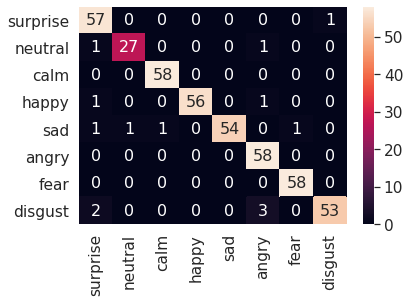

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

predictions = predictions.cpu().numpy()
cm = confusion_matrix(Y_test, predictions)
names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]
df_cm = pd.DataFrame(cm, index=names, columns=names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

# Plot loss

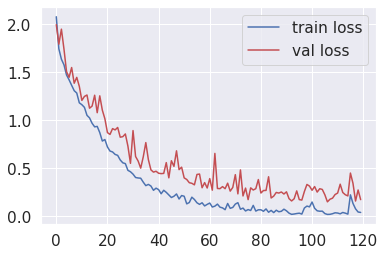

In [23]:
plt.plot(losses,'b')
plt.plot(val_losses,'r')
plt.legend(['train loss','val loss'])